# Heart Rate Peak Detection
Purpose of the notebook:
- This notebook loads in processed EDF data and performs ECG peak detection to calculate heart rate
- This calculation is not saved anywhere, and the process is repeated in the feature_extraction.py script, but it serves as an example for how in works and proof that it does work

# [Data loading](#data_loading)
## [ECG Processing](#ecg_processing)
# [Feature extraction](#feature_extraction)
## [EEG Features](#feature_eeg)
## [ECG Features](#feature_ecg)

### [Frequency Band Exploration](#freq_bands)

In [1]:
import yasa
import mne
import os
import sys
import scipy
import glob
import six
import wfdb
import pytz
import sklearn
import pomegranate
import pyedflib
import sleepecg
import datetime
import wfdb.processing
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import entropy as ent
import seaborn as sns
from matplotlib import mlab as mlab
from sleepecg import detect_heartbeats
import matplotlib.gridspec as gs


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Add the src directory to the path
sys.path.insert(0, '..') 
from src.features.feature_generation_utils import *

<a id='data_loading'></a>

---
# Load in data

---

### Navigate to data folder

In [4]:
# Construct the relative path to the folder containing processed data
data_folder_path = os.path.abspath(os.path.join('..', 'data', 'raw'))
process_data_path = os.path.abspath(os.path.join(data_folder_path, '01_edf_data'))
print(process_data_path)

# Get the current working directory
# current_path = os.getcwd()

# Check if the current directory ends with the "Data" folder
# if not current_path.endswith("01_processed-data"):
#     # Change the current working directory to the "Data" folder, if not already there
#     os.chdir(process_data_path)
#     print(f"Changed directory to: {os.getcwd()}")
# else:
#     print("Already in the correct data directory.")

# Print the current working directory
print("Current Working Directory:", os.getcwd())

/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data
Current Working Directory: /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/notebooks


### Read in header information

In [5]:
# Read the header information to identify channels and their sampling frequencies
info = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_DAY1_PROCESSED.edf',
                           preload=False).info

# Print the channel information
print(info)

# Identify channels and their corresponding sampling frequencies
channels_info = info['chs']
sampling_freq_map = {}

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_DAY1_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>


#### Load in raw data for just day one of the data

In [6]:
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_DAY1_PROCESSED.edf', preload=True,
                          include=['ECG_Raw_Ch1', 'ECG_ICA2'])

# Inspect Data
print('The sampling frequency is:', raw.info['sfreq'])

# Rename channels (replace spaces if any)
channel_renaming_dict = {name: name.replace(' ', '_') for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
print('The channels are:', raw.ch_names)

# Assuming 'raw' is your Raw object from MNE
channel_types = {}

for ch in raw.ch_names:
    if ch.startswith('ECG'):
        channel_types[ch] = 'ecg'

# Now set the channel types
raw.set_channel_types(channel_types)
print()

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_DAY1_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...
The sampling frequency is: 500.0
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2']



#### Get metadata from file

Get start time, channel names, etc.

In [7]:
# Extract the measurement date (start time) from raw.info
start_time = raw.info['meas_date']
fs = raw.info['sfreq']

# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')

# Convert to datetime object in PST
if isinstance(start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = start_time.replace(tzinfo=None).astimezone(pst_timezone)
elif isinstance(start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(start_time))
else:
    # Handle other formats if necessary
    pass

# Calculate the recording duration in seconds
recording_duration_seconds = len(raw) / fs

# Calculate the recording end datetime
recording_end_datetime = recording_start_datetime + datetime.timedelta(seconds=recording_duration_seconds)

# Calculate duration as a timedelta object
duration_timedelta = datetime.timedelta(seconds=recording_duration_seconds)

# Create a time index
#time_index = pd.date_range(recoring_start_datetime, recording_end_datetime)

# Format duration into days, hours, minutes, and seconds
days = duration_timedelta.days
hours, remainder = divmod(duration_timedelta.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print('The start time in PST (Los Angeles) is:', recording_start_datetime)
print('The end time in PST (Los Angeles) is:', recording_end_datetime)
print(f'Duration: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds')


The start time in PST (Los Angeles) is: 2019-10-25 08:21:02-07:00
The end time in PST (Los Angeles) is: 2019-10-26 08:21:02-07:00
Duration: 1 days, 0 hours, 0 minutes, 0 seconds


<a id='ecg_processing'></a>

---
## ECG Pre-Processing

---

Performing peak-detection and corrections with `sleepecg` package. 

Many thanks to Sam Proell's helpful tutorial on the topic:
https://www.samproell.io/posts/signal/ecg-library-comparison/

For the seal Wednesday, the ECG sensor isn't attached and stabilized until around 2:50pm, PCT

### Step 1: Select ECG Channel for Pre-Processing

In [ ]:
# Find all channel names that contain "ECG"
ecg_channels = [ch for ch in raw.info['ch_names'] if 'ECG' in ch]

# Help user define which should be used by visualizing each to find the better channel
# Define the duration to plot (in seconds)
start_str = "10/25/2019 20:30:30"
start_time = datetime.datetime.strptime(start_str, '%m/%d/%Y %H:%M:%S')
start_time = pst_timezone.localize(start_time)
time_diff = (start_time - recording_start_datetime).total_seconds()

duration = 60 # 1 minute
fs = raw.info['sfreq']  # Sampling frequency

# Calculate the starting index
start_index = int(fs * time_diff)

# Extract a segment starting from start_index
end_index = start_index + int(duration * fs)

# Create a figure
fig = go.Figure()

# Offset amount
offset = 0.005
current_offset = 0  # Start with no offset for the first channel

# Plot the first 30 seconds of all ECG channels
for idx, channel in enumerate(ecg_channels):
    ecg_data = raw.get_data(channel).copy()[0, start_index:end_index]
    print(len(ecg_data))
    time_vector = raw.times[start_index:end_index]

    # Offset the ECG data for visualization
    ecg_data_with_offset = ecg_data + (idx * current_offset)
    
    # Add the ECG data trace for each channel
    fig.add_trace(go.Scatter(x=time_vector, y=ecg_data_with_offset, mode='lines', 
                             name= f'{idx} - {channel}'))

    # Increase the offset for the next channel
    current_offset += offset

# Update layout for better readability
fig.update_layout(title='ECG Channel Comparison',
                  xaxis_title='Time (seconds)',
                  yaxis_title='Amplitude',
                  showlegend=True)

# Show the figure
fig.show()

### Step 2: Perform peak-detection

Use the channel index in the legend above to select a channel to use for peak detection.

Peak detection ran successfully.


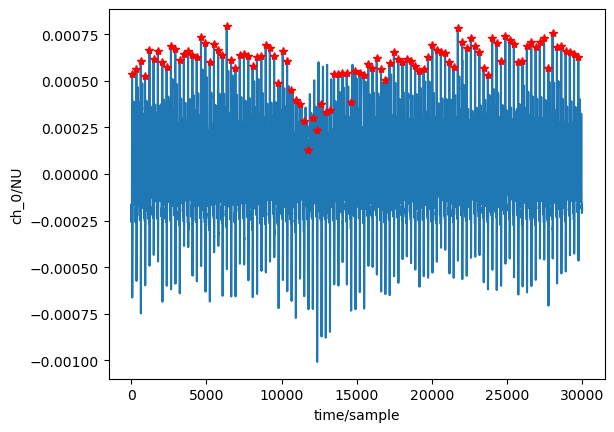

In [9]:
# Peak-detection
start_str = "10/25/2019 20:30:30"
start_time = datetime.datetime.strptime(start_str, '%m/%d/%Y %H:%M:%S')
start_time = pst_timezone.localize(start_time)
time_diff = (start_time - recording_start_datetime).total_seconds()

duration = 60 # 1 minute
fs = raw.info['sfreq']  # Sampling frequency

# Calculate the starting index
start_index = int(fs * time_diff)

# Extract a segment starting from start_index
end_index = start_index + int(duration * fs)

# Manually set the index of the channel you want to use for peak detection
# INPUT HERE:

# Now use this index to extract the data for peak detection
ecg_data = raw.get_data(['ECG_Raw_Ch1'])[0].copy()

ecg_segment = ecg_data[start_index:end_index]

rpeaks = detect_heartbeats(ecg_data, fs) # using sleepecg
rpeaks_segment = np.array(
    [rp - start_index for rp in rpeaks if start_index <= rp < end_index]
)

print('Peak detection ran successfully.')

rpeaks_corrected = wfdb.processing.correct_peaks(
    ecg_data, rpeaks, search_radius=200, smooth_window_size=50, peak_dir="up"
)

rpeaks_corrected_segment = np.array(
    [rp - start_index for rp in rpeaks_corrected if start_index <= rp < end_index]
)

# MIGHT HAVE TO UPDATE search_radiaus
wfdb.plot_items(
    ecg_segment, [rpeaks_corrected_segment]
)

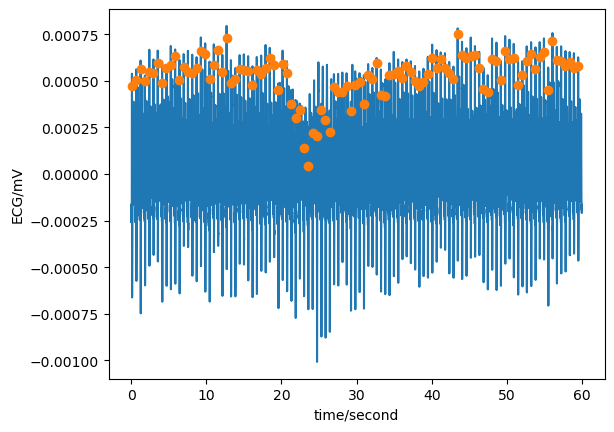

In [10]:
# less fancy: plt.plot(ecg_signal); plt.plot(rpeaks, ecg_signal[rpeaks], "x")
fig = wfdb.plot_items(
    ecg_segment,
    [rpeaks_segment],
    fs=fs,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
)

### Visualizing Peak Detection Results

Generating a plot at a given timestamp to visualize the results of the ECG peak-detection method.

In [ ]:
# Start string and parsing
start_str = "10/25/2019 20:30:30"
start_time = datetime.datetime.strptime(start_str, '%m/%d/%Y %H:%M:%S')
start_time = pst_timezone.localize(start_time)
time_diff = (start_time - recording_start_datetime).total_seconds()

duration = 600 # 10 minutes
fs = raw.info['sfreq']  # Sampling frequency

# Calculate the starting index
start_index = int(fs * time_diff)

# Extract a segment starting from start_index
end_index = start_index + int(duration * fs)
print(start_index, end_index)
ecg_segment = ecg_data[start_index:end_index]

# Create a time vector for the segment
segment_time = [i / fs for i in range(end_index - start_index)]

# Calculate R-peaks within the segment's range
rpeaks_segment = [rp for rp in rpeaks if start_index <= rp < end_index]
rpeaks_segment_time = [(rp - start_index) / fs for rp in rpeaks_segment]
rpeaks_segment_amplitudes = [ecg_segment[rp - start_index] for rp in rpeaks_segment]

# Calculate the time points for the corrected R-peaks within the segment
rpeaks_corrected_segment = [rp for rp in rpeaks_corrected if start_index <= rp < end_index]
rpeaks_corrected_segment_time = [(rp - start_index) / fs for rp in rpeaks_corrected_segment]
rpeaks_corrected_amplitudes = [ecg_segment[rp - start_index] for rp in rpeaks_corrected_segment]

# Calculate heart rates between R-peaks
heart_rates = [60 / ((rpeaks_segment[i+1] - rpeaks_segment[i]) / fs) for i in range(len(rpeaks_segment) - 1)]
# Create a heart rate array matching the frequency of the ECG trace
hr_data = np.zeros_like(ecg_segment)
# Assign heart rate values to the intervals between R-peaks
for i in range(len(rpeaks_segment) - 1):
    start_idx = rpeaks_segment[i] - start_index
    end_idx = rpeaks_segment[i+1] - start_index
    hr_data[start_idx:end_idx] = heart_rates[i]

# Calculate heart rates between R-peaks
heart_rates2 = [60 / ((rpeaks_corrected_segment[i+1] - rpeaks_corrected_segment[i]) / fs) for i in range(len(
    rpeaks_corrected_segment) - 1)]
# Create a heart rate array matching the frequency of the ECG trace
hr_data2 = np.zeros_like(ecg_segment)
# Assign heart rate values to the intervals between R-peaks
for i in range(len(rpeaks_corrected_segment) - 1):
    start_idx = rpeaks_corrected_segment[i] - start_index
    end_idx = rpeaks_corrected_segment[i+1] - start_index
    hr_data2[start_idx:end_idx] = heart_rates2[i]

# Create subplots with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Add ECG data trace
fig.add_trace(go.Scatter(x=segment_time, y=ecg_segment[:len(segment_time)], mode='lines', name='ECG'),
              row=1, col=1)

# Add original R-peaks as red scatter points
fig.add_trace(go.Scatter(x=rpeaks_segment_time, y=rpeaks_segment_amplitudes[:len(rpeaks_segment_time)],
                         mode='markers', name='R-peaks',
                         marker=dict(size=5, color='red')), row=1, col=1)

# Add corrected R-peaks as orange scatter points
fig.add_trace(go.Scatter(x=rpeaks_corrected_segment_time,
                         y=rpeaks_corrected_amplitudes[:len(rpeaks_corrected_segment_time)], mode='markers',
                         name='Corrected R-peaks', marker=dict(size=5, color='orange')), row=1, col=1)

# Add heart rate trace
fig.add_trace(go.Scatter(x=segment_time, y=hr_data, mode='lines', name='Heart Rate',
                         line=dict(color='red', width=3)),
              row=2, col=1)

# Add heart rate trace
fig.add_trace(go.Scatter(x=segment_time, y=hr_data2, mode='lines', name='Heart Rate "Corrected"',
                         line=dict(color='blue', width=2)),
              row=2, col=1)

# Update layout for better readability
fig.update_layout(title=f'ECG Data and Heart Rate ({duration} seconds)',
                  xaxis_title='Time (seconds)',
                  yaxis_title='Amplitude / Heart Rate',
                  showlegend=True)

# Show the figure
fig.show()
